## 딥러닝 영상처리
# DCGAN : MNIST

- GAN : Generative Adversarial Networks
- DCGAN : Deep Convolutional GAN
- Generator(생성자) / Discriminator(판별자)

<img src='https://wiki.pathmind.com/images/wiki/GANs.png' />
(출처 : https://wiki.pathmind.com/generative-adversarial-network-gan)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### MNIST 로딩

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train = X_train/255
X_test = X_test/255

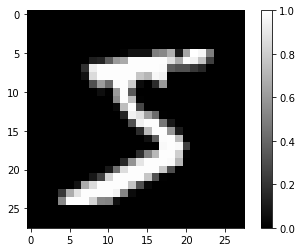

In [5]:
plt.imshow(X_train[0], cmap='gray')
plt.colorbar()

In [6]:
X_train = X_train[:,:,:,np.newaxis] # X_train.reshape(-1,28,28,1)
X_test = X_test[:,:,:,np.newaxis]

In [7]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((60000, 28, 28, 1), dtype('float64'), 1.0, 0.0)

In [8]:
X_test.shape

(10000, 28, 28, 1)

### 판별자 정의

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop

In [10]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928

<img src='https://www.researchgate.net/profile/Sepp_Hochreiter/publication/284579051/figure/fig1/AS:614057178578955@1523414048184/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs.png' />
(출처: https://www.researchgate.net/figure/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs_fig1_284579051)

In [11]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])
    # decay 값이 클수록 새롭게(처음으로) 변경되는 가중치를 많이 변화시킨다 (디폴트:0)

d:\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### 생성자 정의

In [12]:
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512 

### 적대망 정의
- 생성자로 생성한 이미지가 판별자에 의해 '실제이미지' 로 판별되도록 생성자의 가중치를 조절한다

In [13]:
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         1301505   
_________________________________________________________________
model (Functional)           (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [14]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

### 훈련하기
- fake images: 0, real images: 1
- 1 step 에 10초 정도 소요됨
- C:\khh\프로그래밍\CNN\gan_images 폴더에 'fake_9.png' 형태로 저장함
- 생성자 모델을 'gan_mnist_generator_1000.h5' 로 저장함

In [15]:
from tensorflow.keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(1000):
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step)+'.png')

Step: 00001,  [0.6924899816513062, 0.734375, 0.949485182762146, 0.0]
Step: 00002,  [0.5899107456207275, 0.5390625, 1.0404406785964966, 0.0]
Step: 00003,  [0.4726482033729553, 0.7421875, 0.7946406006813049, 0.0]
Step: 00004,  [0.3440825939178467, 1.0, 0.9734817147254944, 0.0]
Step: 00005,  [0.2337840050458908, 0.9921875, 0.22822988033294678, 1.0]
Step: 00006,  [0.4220341444015503, 0.5, 1.096146821975708, 0.0]
Step: 00007,  [0.24069030582904816, 0.9453125, 0.6036324501037598, 1.0]
Step: 00008,  [0.13096478581428528, 1.0, 0.46342140436172485, 1.0]
Step: 00009,  [0.08203454315662384, 1.0, 0.38525688648223877, 1.0]
Step: 00010,  [0.06606360524892807, 1.0, 0.32334256172180176, 1.0]
Step: 00011,  [0.058138925582170486, 1.0, 0.2566710114479065, 1.0]
Step: 00012,  [0.04009086638689041, 1.0, 0.20778240263462067, 1.0]
Step: 00013,  [0.03322372958064079, 1.0, 0.16711288690567017, 1.0]
Step: 00014,  [0.026666194200515747, 1.0, 0.13662585616111755, 1.0]
Step: 00015,  [0.026170261204242706, 1.0, 0.10

Step: 00118,  [0.0031991901341825724, 1.0, 0.04965009540319443, 1.0]
Step: 00119,  [0.003514328505843878, 1.0, 0.020221978425979614, 1.0]
Step: 00120,  [0.00014025620475877076, 1.0, 0.014871221035718918, 1.0]
Step: 00121,  [0.00040354998782277107, 1.0, 0.011251882649958134, 1.0]
Step: 00122,  [0.00043062385520897806, 1.0, 0.008893510326743126, 1.0]
Step: 00123,  [0.00017130776541307569, 1.0, 0.007558278273791075, 1.0]
Step: 00124,  [0.0007402630872093141, 1.0, 0.005693371873348951, 1.0]
Step: 00125,  [0.00022676808293908834, 1.0, 0.0047421264462172985, 1.0]
Step: 00126,  [3.716560240718536e-05, 1.0, 0.004406294785439968, 1.0]
Step: 00127,  [9.86472878139466e-05, 1.0, 0.003932200372219086, 1.0]
Step: 00128,  [0.00013390557433012873, 1.0, 0.0034789058845490217, 1.0]
Step: 00129,  [9.550659160595387e-05, 1.0, 0.0031604995019733906, 1.0]
Step: 00130,  [0.00027811992913484573, 1.0, 0.002722484990954399, 1.0]
Step: 00131,  [0.0005623307661153376, 1.0, 0.0023472621105611324, 1.0]
Step: 00132,

Step: 00235,  [0.18384382128715515, 0.984375, 2.747845411300659, 0.0]
Step: 00236,  [0.12145469337701797, 0.9609375, 0.00045413372572511435, 1.0]
Step: 00237,  [0.006723284721374512, 1.0, 0.0005982830771245062, 1.0]
Step: 00238,  [0.005729913245886564, 1.0, 0.0008325380040332675, 1.0]
Step: 00239,  [0.005003485828638077, 1.0, 0.0010265873279422522, 1.0]
Step: 00240,  [0.004109764471650124, 1.0, 0.0012448889901861548, 1.0]
Step: 00241,  [0.0035766377113759518, 1.0, 0.001570193562656641, 1.0]
Step: 00242,  [0.003114295657724142, 1.0, 0.0018093616236001253, 1.0]
Step: 00243,  [0.0028627398423850536, 1.0, 0.0020365570671856403, 1.0]
Step: 00244,  [0.002573623787611723, 1.0, 0.002504713600501418, 1.0]
Step: 00245,  [0.0024158249143511057, 1.0, 0.0027341742534190416, 1.0]
Step: 00246,  [0.0021615400910377502, 1.0, 0.0030515212565660477, 1.0]
Step: 00247,  [0.0020442726090550423, 1.0, 0.003344315802678466, 1.0]
Step: 00248,  [0.0018390652257949114, 1.0, 0.003646674333140254, 1.0]
Step: 00249,

Step: 00351,  [0.14794808626174927, 0.953125, 9.200027465820312, 0.0]
Step: 00352,  [1.5818098783493042, 0.65625, 1.6123683508340036e-06, 1.0]
Step: 00353,  [0.34566354751586914, 0.8203125, 0.0017648717621341348, 1.0]
Step: 00354,  [0.013512203469872475, 1.0, 0.002252488164231181, 1.0]
Step: 00355,  [0.012107697315514088, 1.0, 0.003242040053009987, 1.0]
Step: 00356,  [0.010065396316349506, 1.0, 0.0038678785786032677, 1.0]
Step: 00357,  [0.009564992971718311, 1.0, 0.004060937557369471, 1.0]
Step: 00358,  [0.010061142034828663, 1.0, 0.0052146995440125465, 1.0]
Step: 00359,  [0.00839752797037363, 1.0, 0.0054321447387337685, 1.0]
Step: 00360,  [0.008811655454337597, 1.0, 0.005782414227724075, 1.0]
Step: 00361,  [0.008656979538500309, 1.0, 0.0060986122116446495, 1.0]
Step: 00362,  [0.008228563703596592, 1.0, 0.007212758529931307, 1.0]
Step: 00363,  [0.00859005842357874, 1.0, 0.007604700047522783, 1.0]
Step: 00364,  [0.010244475677609444, 1.0, 0.009839792735874653, 1.0]
Step: 00365,  [0.0231

Step: 00467,  [0.14595255255699158, 0.96875, 0.08956894278526306, 1.0]
Step: 00468,  [0.16974151134490967, 0.96875, 3.4003162384033203, 0.0]
Step: 00469,  [0.19383135437965393, 0.90625, 0.01781940460205078, 1.0]
Step: 00470,  [0.3353819251060486, 0.8125, 4.161569595336914, 0.0]
Step: 00471,  [0.134248286485672, 0.9609375, 0.36877015233039856, 1.0]
Step: 00472,  [0.13830900192260742, 1.0, 3.2222728729248047, 0.0]
Step: 00473,  [0.10562306642532349, 0.9609375, 0.6024707555770874, 0.765625]
Step: 00474,  [0.39837250113487244, 0.75, 8.945858001708984, 0.0]
Step: 00475,  [1.7745081186294556, 0.5078125, 0.004002915229648352, 1.0]
Step: 00476,  [0.5884056091308594, 0.5546875, 1.1283912658691406, 0.0]
Step: 00477,  [0.21207714080810547, 0.953125, 1.6919927597045898, 0.0]
Step: 00478,  [0.16211144626140594, 0.96875, 0.8778856992721558, 0.09375]
Step: 00479,  [0.31360694766044617, 0.890625, 2.064218044281006, 0.0]
Step: 00480,  [0.2279297113418579, 0.921875, 0.5327457189559937, 0.953125]
Step: 0

Step: 00583,  [0.02294190786778927, 1.0, 0.0037338498514145613, 1.0]
Step: 00584,  [0.013923456892371178, 1.0, 0.004718909040093422, 1.0]
Step: 00585,  [0.0217059887945652, 0.9921875, 0.004449114203453064, 1.0]
Step: 00586,  [0.01249583438038826, 1.0, 0.019372783601284027, 1.0]
Step: 00587,  [0.007260273676365614, 1.0, 0.025710929185152054, 1.0]
Step: 00588,  [0.022306624799966812, 0.9921875, 0.006479593459516764, 1.0]
Step: 00589,  [0.03320895507931709, 0.9921875, 0.017337512224912643, 1.0]
Step: 00590,  [0.010665512643754482, 1.0, 0.01587444543838501, 1.0]
Step: 00591,  [0.018288414925336838, 1.0, 0.018414653837680817, 1.0]
Step: 00592,  [0.015165730379521847, 0.9921875, 0.016871020197868347, 1.0]
Step: 00593,  [0.007221123203635216, 1.0, 0.04913242533802986, 1.0]
Step: 00594,  [0.016139203682541847, 0.9921875, 0.000609719892963767, 1.0]
Step: 00595,  [0.035628192126750946, 0.9921875, 1.6705423593521118, 0.0]
Step: 00596,  [0.09299631416797638, 0.96875, 1.0070575484633082e-07, 1.0]
S

Step: 00701,  [0.24536283314228058, 0.9296875, 1.1061614751815796, 0.1875]
Step: 00702,  [0.2873483896255493, 0.8984375, 5.594973564147949, 0.0]
Step: 00703,  [0.6560676097869873, 0.6796875, 0.008860294707119465, 1.0]
Step: 00704,  [1.1051658391952515, 0.5390625, 5.742425918579102, 0.0]
Step: 00705,  [0.5681936740875244, 0.78125, 0.6130958795547485, 0.578125]
Step: 00706,  [0.33835896849632263, 0.84375, 3.434798240661621, 0.0]
Step: 00707,  [0.18665730953216553, 0.953125, 1.5885916948318481, 0.046875]
Step: 00708,  [0.1442008763551712, 0.953125, 1.8697335720062256, 0.046875]
Step: 00709,  [0.22651243209838867, 0.890625, 0.23893195390701294, 0.96875]
Step: 00710,  [0.14982588589191437, 0.9609375, 0.8068631291389465, 0.453125]
Step: 00711,  [0.18213994801044464, 0.9375, 0.4727563261985779, 0.796875]
Step: 00712,  [0.19861796498298645, 0.9296875, 0.5675213932991028, 0.71875]
Step: 00713,  [0.16025543212890625, 0.9296875, 0.8424451351165771, 0.359375]
Step: 00714,  [0.15712396800518036, 0.

Step: 00813,  [0.43050095438957214, 0.8046875, 2.657414436340332, 0.015625]
Step: 00814,  [0.31740817427635193, 0.890625, 1.3381226062774658, 0.203125]
Step: 00815,  [0.22747831046581268, 0.921875, 1.9018089771270752, 0.015625]
Step: 00816,  [0.2724628150463104, 0.921875, 1.2304325103759766, 0.25]
Step: 00817,  [0.28172916173934937, 0.8671875, 2.60086727142334, 0.03125]
Step: 00818,  [0.35683122277259827, 0.828125, 0.9840759038925171, 0.34375]
Step: 00819,  [0.4021138846874237, 0.8359375, 2.7630152702331543, 0.015625]
Step: 00820,  [0.3197227418422699, 0.8203125, 0.8531215786933899, 0.46875]
Step: 00821,  [0.4091367721557617, 0.8203125, 3.5614709854125977, 0.0]
Step: 00822,  [0.3768446445465088, 0.8046875, 1.1266586780548096, 0.21875]
Step: 00823,  [0.45191001892089844, 0.828125, 3.002999782562256, 0.0]
Step: 00824,  [0.3917391002178192, 0.796875, 0.9200239777565002, 0.40625]
Step: 00825,  [0.31736260652542114, 0.890625, 1.7910939455032349, 0.015625]
Step: 00826,  [0.2665819525718689, 

Step: 00924,  [0.6860384941101074, 0.6171875, 0.5837941765785217, 0.71875]
Step: 00925,  [0.6284748315811157, 0.640625, 1.8670473098754883, 0.0]
Step: 00926,  [0.6079161763191223, 0.640625, 0.6323369145393372, 0.6875]
Step: 00927,  [0.6349813938140869, 0.625, 1.9277687072753906, 0.0]
Step: 00928,  [0.5778921842575073, 0.671875, 0.6243586540222168, 0.65625]
Step: 00929,  [0.5901163220405579, 0.625, 1.106313705444336, 0.234375]
Step: 00930,  [0.5145369172096252, 0.7265625, 0.7427622675895691, 0.5]
Step: 00931,  [0.6136631965637207, 0.6875, 1.5414624214172363, 0.03125]
Step: 00932,  [0.5496972799301147, 0.7109375, 0.6930944919586182, 0.578125]
Step: 00933,  [0.524225115776062, 0.75, 0.9889649152755737, 0.21875]
Step: 00934,  [0.5501733422279358, 0.7578125, 0.7297797203063965, 0.515625]
Step: 00935,  [0.4998026490211487, 0.796875, 0.9380282163619995, 0.28125]
Step: 00936,  [0.6100921034812927, 0.65625, 0.9282601475715637, 0.375]
Step: 00937,  [0.5017029047012329, 0.7890625, 0.7168096303939

In [27]:
generator.save('gan_mnist_generator_20.h5')

- 총 1000번 배치 실행 (이전 400번 + 신규 600번)

In [38]:
from keras.preprocessing import image

batch_size = 64

for step in range(400,1000): # 40000
    idx = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[idx]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, [%.3f, %.3f, %.3f, %.3f]' % (step+1,d_loss,d_acc,a_loss,a_acc))
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step)+'.png')

C:\Anaconda3\envs\py36\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00401, [0.600, 0.719, 0.907, 0.188]
Step: 00402, [0.611, 0.680, 0.673, 0.578]
Step: 00403, [0.604, 0.633, 1.126, 0.078]
Step: 00404, [0.623, 0.641, 0.531, 0.812]
Step: 00405, [0.664, 0.547, 1.288, 0.016]
Step: 00406, [0.709, 0.555, 0.490, 0.844]
Step: 00407, [0.706, 0.508, 1.568, 0.000]
Step: 00408, [0.698, 0.562, 0.541, 0.781]
Step: 00409, [0.710, 0.516, 1.197, 0.031]
Step: 00410, [0.608, 0.656, 0.728, 0.453]
Step: 00411, [0.572, 0.719, 0.889, 0.141]
Step: 00412, [0.610, 0.703, 0.822, 0.219]
Step: 00413, [0.606, 0.664, 1.181, 0.047]
Step: 00414, [0.633, 0.648, 0.626, 0.656]
Step: 00415, [0.655, 0.570, 1.514, 0.016]
Step: 00416, [0.708, 0.539, 0.560, 0.766]
Step: 00417, [0.655, 0.547, 1.259, 0.016]
Step: 00418, [0.698, 0.562, 0.544, 0.812]
Step: 00419, [0.636, 0.578, 1.112, 0.062]
Step: 00420, [0.619, 0.664, 0.724, 0.484]
Step: 00421, [0.587, 0.672, 0.978, 0.188]
Step: 00422, [0.589, 0.703, 0.775, 0.375]
Step: 00423, [0.627, 0.609, 0.988, 0.094]
Step: 00424, [0.632, 0.656, 0.781,

Step: 00597, [0.581, 0.688, 0.560, 0.719]
Step: 00598, [0.617, 0.594, 1.697, 0.016]
Step: 00599, [0.676, 0.578, 0.450, 0.844]
Step: 00600, [0.635, 0.578, 1.215, 0.094]
Step: 00601, [0.608, 0.641, 0.909, 0.266]
Step: 00602, [0.555, 0.703, 1.139, 0.047]
Step: 00603, [0.565, 0.680, 0.823, 0.312]
Step: 00604, [0.583, 0.727, 1.379, 0.047]
Step: 00605, [0.609, 0.641, 0.637, 0.531]
Step: 00606, [0.629, 0.594, 1.431, 0.047]
Step: 00607, [0.602, 0.641, 0.537, 0.812]
Step: 00608, [0.591, 0.656, 1.318, 0.047]
Step: 00609, [0.604, 0.656, 0.612, 0.719]
Step: 00610, [0.591, 0.617, 1.462, 0.016]
Step: 00611, [0.653, 0.594, 0.601, 0.734]
Step: 00612, [0.541, 0.695, 1.088, 0.156]
Step: 00613, [0.561, 0.734, 0.605, 0.672]
Step: 00614, [0.547, 0.727, 1.015, 0.203]
Step: 00615, [0.569, 0.742, 0.833, 0.375]
Step: 00616, [0.560, 0.750, 1.148, 0.078]
Step: 00617, [0.527, 0.727, 0.742, 0.469]
Step: 00618, [0.573, 0.695, 1.315, 0.062]
Step: 00619, [0.559, 0.664, 0.548, 0.719]
Step: 00620, [0.665, 0.562, 1.839,

Step: 00793, [0.600, 0.664, 0.796, 0.391]
Step: 00794, [0.547, 0.727, 1.374, 0.047]
Step: 00795, [0.610, 0.625, 0.577, 0.719]
Step: 00796, [0.688, 0.594, 1.511, 0.047]
Step: 00797, [0.718, 0.555, 0.495, 0.828]
Step: 00798, [0.674, 0.562, 1.445, 0.016]
Step: 00799, [0.583, 0.680, 0.705, 0.516]
Step: 00800, [0.609, 0.625, 1.259, 0.031]
Step: 00801, [0.615, 0.656, 0.707, 0.594]
Step: 00802, [0.700, 0.555, 1.177, 0.172]
Step: 00803, [0.596, 0.719, 0.689, 0.484]
Step: 00804, [0.611, 0.656, 1.259, 0.094]
Step: 00805, [0.607, 0.656, 0.652, 0.578]
Step: 00806, [0.622, 0.695, 1.423, 0.031]
Step: 00807, [0.671, 0.617, 0.535, 0.734]
Step: 00808, [0.667, 0.570, 1.305, 0.016]
Step: 00809, [0.617, 0.656, 0.631, 0.656]
Step: 00810, [0.662, 0.602, 1.076, 0.156]
Step: 00811, [0.596, 0.703, 0.730, 0.453]
Step: 00812, [0.590, 0.719, 1.033, 0.141]
Step: 00813, [0.567, 0.758, 0.808, 0.391]
Step: 00814, [0.615, 0.688, 0.794, 0.406]
Step: 00815, [0.552, 0.766, 0.948, 0.188]
Step: 00816, [0.569, 0.789, 0.789,

Step: 00989, [0.605, 0.641, 0.642, 0.672]
Step: 00990, [0.585, 0.648, 1.292, 0.078]
Step: 00991, [0.607, 0.664, 0.738, 0.406]
Step: 00992, [0.623, 0.656, 1.091, 0.156]
Step: 00993, [0.536, 0.773, 0.912, 0.266]
Step: 00994, [0.595, 0.680, 1.148, 0.109]
Step: 00995, [0.614, 0.672, 0.686, 0.672]
Step: 00996, [0.646, 0.602, 1.600, 0.016]
Step: 00997, [0.707, 0.570, 0.710, 0.438]
Step: 00998, [0.630, 0.609, 1.274, 0.047]
Step: 00999, [0.638, 0.609, 0.569, 0.703]
Step: 01000, [0.665, 0.555, 1.167, 0.094]


In [16]:
generator.save('gan_mnist_generator_1000.h5')

In [17]:
np.save('gan_mnist_log.npy', logs)

### 결과 분석

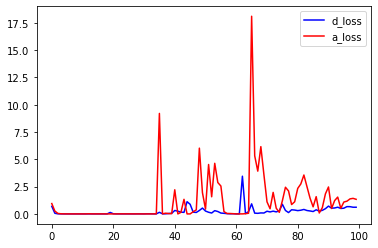

In [18]:
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

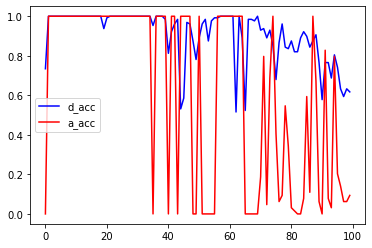

In [19]:
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

- 결과 비교
<img src='https://d33wubrfki0l68.cloudfront.net/1439d140302850f4652f4def43d264b7afa39e65/81f84/assets/images/gan-intro/mnistkeras_19_0.png' />
(출처: https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/)

### 숫자 이미지 생성

In [29]:
from keras.models import load_model

#generator = load_model('gan_mnist_generator_1000.h5')

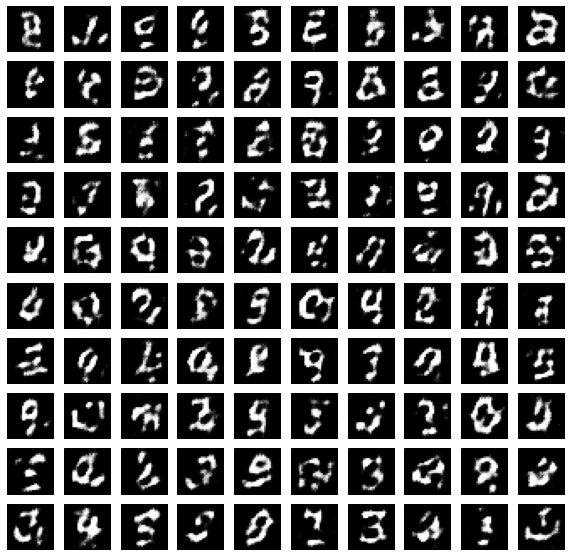

In [20]:
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')